# Spark streaming

## Data loading

We'll be using [Facebook Large Page-Page Network dataset](https://snap.stanford.edu/data/facebook-large-page-page-network.html).

Load:
- edges from `"musae_facebook_edges.csv"` file, format "id1,id2"
- attributes from `"musae_facebook_target.csv"` file, format "id,facebook_id,page_name,page_type"

Count number of edges and vertices.

I deleted header and empty last line in each file manually to have uniform lines.

In [1]:
import org.apache.spark._
import org.apache.spark.graphx._
import org.apache.spark.sql._
import org.apache.spark.rdd.RDD

Intitializing Scala interpreter ...

Spark Web UI available at http://DESKTOP-HNLVNJD.mshome.net:4040
SparkContext available as 'sc' (version = 3.1.2, master = local[*], app id = local-1638904266079)
SparkSession available as 'spark'


import org.apache.spark._
import org.apache.spark.graphx._
import org.apache.spark.sql._
import org.apache.spark.rdd.RDD


In [2]:
val sc = (
    SparkContext
    .getOrCreate(
        new SparkConf()
        .setAppName("GraphX lab")
        .setMaster("local[*]")
    )
)

val vertices: RDD[(Long, (String, String))] = (
    sc.textFile("musae_facebook_target.csv")
    .map(line => {
        val x = line.split(",");
        (x(0).toLong, (x(2), x(3)))
    })
)

val edges: RDD[Edge[String]] = (
    sc.textFile("musae_facebook_edges.csv")
    .map(line => {
        val x = line.split(",");
        Edge(x(0).toLong, x(1).toLong, "")
    })
)

val default_node = ("", "")

val graph: Graph[(String, String), String] = Graph(vertices, edges, default_node)

sc: org.apache.spark.SparkContext = org.apache.spark.SparkContext@5217e75a
vertices: org.apache.spark.rdd.RDD[(Long, (String, String))] = MapPartitionsRDD[2] at map at <console>:46
edges: org.apache.spark.rdd.RDD[org.apache.spark.graphx.Edge[String]] = MapPartitionsRDD[5] at map at <console>:54
default_node: (String, String) = ("","")
graph: org.apache.spark.graphx.Graph[(String, String),String] = org.apache.spark.graphx.impl.GraphImpl@3b82d272


In [3]:
graph.vertices.count()

res0: Long = 22470


In [4]:
graph.edges.count()

res1: Long = 171002


## Graph and subgraphs connectivity

Check if the graph is connected. Are the subgraphs for "politician" and "company" page types connected?

In [7]:
def isConnected(graph: Graph[(String, String), String]): Boolean = {
    graph.vertices.count() == graph.connectedComponents().vertices.count()
}

isConnected: (graph: org.apache.spark.graphx.Graph[(String, String),String])Boolean


In [8]:
println(isConnected(graph))

true


In [9]:
val politicians_graph = graph.subgraph(
    vpred = { case (id, (page_name, page_type)) => page_type == "politician" }
)

println(isConnected(politicians_graph))

true


politicians_graph: org.apache.spark.graphx.Graph[(String, String),String] = org.apache.spark.graphx.impl.GraphImpl@19fc91d2


In [10]:
val companies_graph = graph.subgraph(
    vpred = { case (id, (page_name, page_type)) => page_type == "company" }
)

println(isConnected(companies_graph))

true


companies_graph: org.apache.spark.graphx.Graph[(String, String),String] = org.apache.spark.graphx.impl.GraphImpl@6701432c


## PageRank and vertex degree ranking

Among the 1000 pages with the highest PageRank value select 50 vertices (print page_name and page_type) with the lowest degree and 50 with the highest degree. Which type was the most popular in each part?

Create a scatter plot of PageRank value (Y axis) vs vertex degree (X axis).

In [11]:
val ranks = graph.pageRank(0.0001).vertices

val rankedVertexDegrees = ranks.join(graph.degrees)

ranks: org.apache.spark.graphx.VertexRDD[Double] = VertexRDDImpl[1817] at RDD at VertexRDD.scala:57
rankedVertexDegrees: org.apache.spark.rdd.RDD[(org.apache.spark.graphx.VertexId, (Double, Int))] = MapPartitionsRDD[1830] at join at <console>:38


In [12]:
rankedVertexDegrees.takeSample(false, 3)

res6: Array[(org.apache.spark.graphx.VertexId, (Double, Int))] = Array((1779,(0.4455408808892897,88)), (17523,(6.451457428879024,102)), (6256,(0.3940901383492063,5)))


In [13]:
val graphWithRankedDegrees = graph.outerJoinVertices(rankedVertexDegrees) {
    (_, data, vertexWithRank) => (
        data._1,  // page_name
        data._2,  // page_type
        vertexWithRank.getOrElse((0.0, 0))._1,  // PageRank value
        vertexWithRank.getOrElse((0.0, 0))._2   // degree
    )
}

graphWithRankedDegrees: org.apache.spark.graphx.Graph[(String, String, Double, Int),String] = org.apache.spark.graphx.impl.GraphImpl@528d5227


In [14]:
graphWithRankedDegrees.vertices.takeSample(false, 3)

res7: Array[(org.apache.spark.graphx.VertexId, (String, String, Double, Int))] = Array((20023,(Personal Argentina,company,0.880418853376254,5)), (12874,(Michael Gidley,politician,1.4011238359565301,60)), (17254,(adidas,company,6.72847835375543,67)))


In [15]:
val top_50 = (
    graphWithRankedDegrees.vertices
    .top(50)
    .map(v => (v._2._2, v._2._1))  // degree, page_type, page_name
    .sorted
)


val last_50 = (
    graphWithRankedDegrees.vertices
    .takeOrdered(50)
    .map(v => (v._2._2, v._2._1))  // degree, page_type, page_name
    .sorted
)

top_50: Array[(String, String)] = Array((" Chapters and Coles"","Indigo), (" Georgetown)"","India in Guyana (High Commission of India), (" Wissenschaft & Digitale Gesellschaft"","Thüringer Ministerium für Wirtschaft), (company,Abarth), (company,Bosch Professional Power Tools and Accessories), (company,CVS Pharmacy), (company,Cathay Pacific Airways), (company,Chupa Chups), (company,Dignity Health), (company,GIORDANO), (company,Imovelweb), (company,Keurig), (company,OLTURSA), (company,Pizzaro), (company,Tottus Perú), (company,Triumph), (company,Yenda), (company,dubdub Stories), (government,Ambassade du Canada en Israël), (government,Australia in Thailand), (government,Camden County Government), (government,City of Los Altos Police Department), (government,EnergySaver.gov), (government,Flo...


In [44]:
for (v <- top_50)
    println(v)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

( Chapters and Coles","Indigo)
( Georgetown)","India in Guyana (High Commission of India)
( Wissenschaft & Digitale Gesellschaft","Th?ringer Ministerium f?r Wirtschaft)
(company,Abarth)
(company,Bosch Professional Power Tools and Accessories)
(company,CVS Pharmacy)
(company,Cathay Pacific Airways)
(company,Chupa Chups)
(company,Dignity Health)
(company,GIORDANO)
(company,Imovelweb)
(company,Keurig)
(company,OLTURSA)
(company,Pizzaro)
(company,Tottus Per?)
(company,Triumph)
(company,Yenda)
(company,dubdub Stories)
(government,Ambassade du Canada en Isra?l)
(government,Australia in Thailand)
(government,Camden County Government)
(government,City of Los Altos Police Department)
(government,EnergySaver.gov)
(government,Florida Division of Historical Resources)
(government,Memphis VA Medical Center)
(government,Michigan Department of Agriculture & Rural Development - MDARD)
(government,Ministerio del Interior - Paraguay)
(government,Monroe County Sheriff's Office)
(government,NYPD 33rd Prec

In [45]:
for (v <- last_50)
    println(v)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(company,Die Techniker (TK))
(company,Digicel)
(company,ESET)
(company,Ford Danmark)
(company,Honey Bunches of Oats)
(company,Hotel Indigo)
(company,Hydro Coco)
(company,Marriott Rewards)
(company,Omoda)
(company,Schweppes Australia)
(company,Shapeways)
(company,Sunrun)
(company,Tahiti Tourisme)
(company,TalkTalk)
(company,TeleCentro)
(company,Volaris)
(government,1st Armored Division Sustainment Brigade)
(government,Army ROTC Fighting Saints Battalion)
(government,Brisbane Water LAC - NSW Police Force)
(government,Consulate General of Switzerland in Montreal)
(government,Embassy of the Netherlands in Uganda)
(government,Ministerio de Comunicaciones de la Rep?blica Argentina)
(government,Municipio de Lomas de Zamora)
(government,NASA Student Launch)
(government,NASA's Marshall Space Flight Center)
(government,NCBI - National Center for Biotechnology Information)
(government,National Institute of General Medical Sciences)
(government,Nuevo Le?n Extraordinario)
(government,Polic?a Nacion

In [16]:
val rankedVertexDegreesValues = (
    rankedVertexDegrees
    .map(v => (v._2._1, v._2._2))
)

rankedVertexDegreesValues.takeSample(false, 3)

rankedVertexDegreesValues: org.apache.spark.rdd.RDD[(Double, Int)] = MapPartitionsRDD[1840] at map at <console>:38
res8: Array[(Double, Int)] = Array((1.0010962196511752,14), (0.3949291843904702,21), (0.5220394640479997,6))


In [17]:
import java.io._

val file = "degree_pagerank.txt"
val writer = new BufferedWriter(new OutputStreamWriter(new FileOutputStream(file)))

writer.write(rankedVertexDegreesValues.collect().mkString(","))
writer.close()


import java.io._
file: String = degree_pagerank.txt
writer: java.io.BufferedWriter = java.io.BufferedWriter@beecab


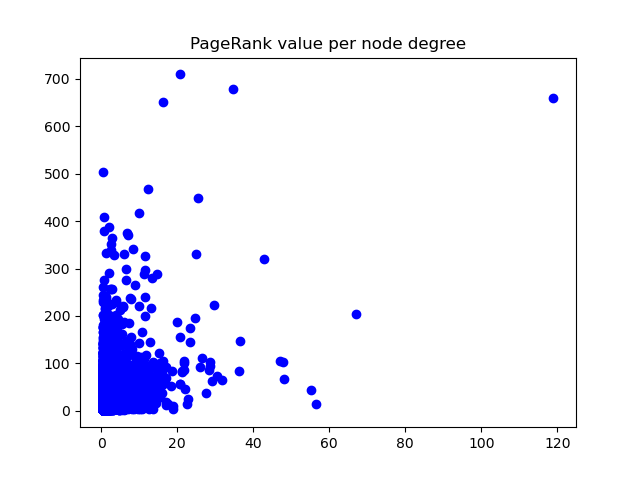

In [49]:
%%python
from tempfile import NamedTemporaryFile

import matplotlib.pyplot as plt
from IPython.display import Image

with open("degree_pagerank.txt") as file:
    text = file.read()

tuples = [tup[:-1] for tup in text.split(",(")]
tuples[0] = tuples[0][1:]
tuples = [tup.split(",") for tup in tuples]
tuples = [(int(tup[1]), float(tup[0])) for tup in tuples]
tuples.sort()

degrees = [degree for pagerank_value, degree in tuples]
pagerank_values = [pagerank_value for pagerank_value, degree in tuples]

plt.clf()
plt.scatter(degrees, pagerank_values, c="b")
plt.title("PageRank value per node degree")

with NamedTemporaryFile(suffix=".png", delete=False) as file:
    plt.savefig(file.name)
    retval = Image(filename=file.name)


## Pregel

Implement the following algorithm using Pregel API:
1. Selected page publishes a fake news post
2. Post is published by $1/3$ randomly chosen contacts of that page
3. In next steps for each page that has already published the post, $1/3$ randomly chosen contacts of that page publish the post

Visualize how the number of pages that published the post change based on the number of steps.

In [40]:
import scala.language.implicitConversions

implicit def bool2int(b:Boolean) = if (b) 1 else 0


def getPublishersNumber(graph: graphx.Graph[Boolean,String], maxIter: Int): Int = {
    val publishGraph = Pregel(
        graph,
        false,
        maxIter,
        activeDirection = EdgeDirection.Out
    )(
        (id, value, msg) => value || (msg && (scala.util.Random.nextFloat() < 0.333)),
        triplet => Iterator((triplet.dstId, triplet.srcAttr)),
        (a, b) => a || b
    )
    
    publishGraph.vertices.collect().map(v => v._2 * 1).sum
}

import scala.language.implicitConversions
bool2int: (b: Boolean)Int
getPublishersNumber: (graph: org.apache.spark.graphx.Graph[Boolean,String], maxIter: Int)Int


In [44]:
val publishId = 1
val initialGraph = ((publishId: VertexId) => graph.mapVertices((id, _) => id == publishId))(publishId)

val publisherNumbers = for (maxIter <- 1 to 32) yield getPublishersNumber(initialGraph, maxIter)

publishId: Int = 1
initialGraph: org.apache.spark.graphx.Graph[Boolean,String] = org.apache.spark.graphx.impl.GraphImpl@16c498f5
publisherNumbers: scala.collection.immutable.IndexedSeq[Int] = Vector(12, 115, 442, 866, 1208, 2602, 3067, 3264, 4097, 4408, 5716, 6099, 5298, 6759, 6980, 4633, 7384, 7444, 6896, 7865, 6044, 7839, 8319, 2642, 8215, 8231, 7098, 8225, 8547, 8568, 8188, 8365)


In [45]:
import java.io._

val file = "publisher_numbers.txt"
val writer = new BufferedWriter(new OutputStreamWriter(new FileOutputStream(file)))

writer.write(publisherNumbers.mkString(","))
writer.close()


import java.io._
file: String = publisher_numbers.txt
writer: java.io.BufferedWriter = java.io.BufferedWriter@2c48273


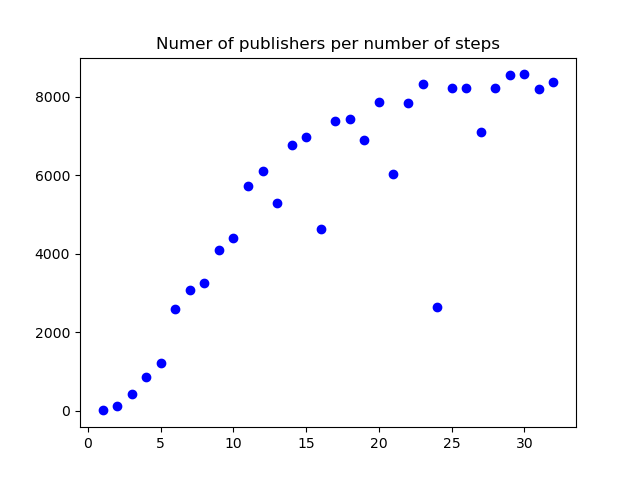

In [50]:
%%python
from tempfile import NamedTemporaryFile

import matplotlib.pyplot as plt
from IPython.display import Image

with open("publisher_numbers.txt") as file:
    text = file.read()

xs = list(range(1, 33))
ys = [int(val) for val in text.split(",")]

plt.clf()
plt.scatter(xs, ys, c="b")
plt.title("Numer of publishers per number of steps")

with NamedTemporaryFile(suffix=".png", delete=False) as file:
    plt.savefig(file.name)
    retval = Image(filename=file.name)


## Checking scale-free property

Plot the distribution of vertex degree of the graph on the logarithmic scale. Is the network scale-free?

In [18]:
val degrees = graph.degrees.map(v => v._2)

degrees.takeSample(false, 10)

degrees: org.apache.spark.rdd.RDD[Int] = MapPartitionsRDD[1842] at map at <console>:39
res10: Array[Int] = Array(1, 12, 43, 48, 1, 5, 6, 4, 11, 2)


In [19]:
val (bins, values) = degrees.histogram(degrees.max)

bins: Array[Double] = Array(1.0, 1.998589562764457, 2.997179125528914, 3.9957686882933707, 4.994358251057828, 5.992947813822285, 6.9915373765867415, 7.990126939351199, 8.988716502115656, 9.987306064880112, 10.98589562764457, 11.984485190409027, 12.983074753173483, 13.981664315937941, 14.980253878702397, 15.978843441466855, 16.97743300423131, 17.97602256699577, 18.974612129760224, 19.973201692524682, 20.97179125528914, 21.970380818053595, 22.968970380818053, 23.96755994358251, 24.966149506346966, 25.964739069111424, 26.963328631875882, 27.96191819464034, 28.960507757404795, 29.959097320169253, 30.95768688293371, 31.956276445698165, 32.95486600846262, 33.95345557122708, 34.95204513399154, 35.950634696756, 36.94922425952045, 37.94781382228491, 38.946403385049365, 39.94499294781382, 40.9435...


In [22]:
import java.io._

val file = "histogram_values.txt"
val writer = new BufferedWriter(new OutputStreamWriter(new FileOutputStream(file)))

writer.write(values.mkString(","))
writer.close()


import java.io._
file: String = histogram_values.txt
writer: java.io.BufferedWriter = java.io.BufferedWriter@5f16fcf6


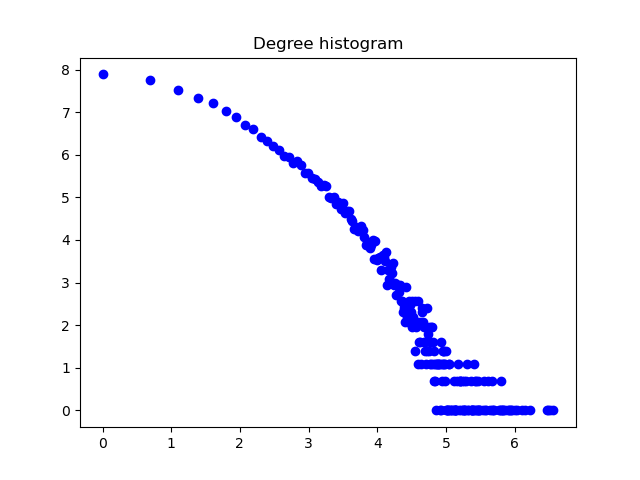

In [58]:
%%python
from tempfile import NamedTemporaryFile

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image

with open("histogram_values.txt") as file:
    text = file.read()

ys = np.array([int(val) for val in text.split(",")])
xs = list(range(1, len(ys) + 1))

plt.clf()
plt.scatter(np.log(xs), np.log(ys), color="b")
plt.title("Degree histogram")

with NamedTemporaryFile(suffix=".png", delete=False) as file:
    plt.savefig(file.name)
    retval = Image(filename=file.name)


Network is indeed scale-free (compare log-log plot e.g. with [this one](https://mathinsight.org/scale_free_network)).